In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Count files in classes**

normal_augmented_data has 1093 files.
pneumonia_augmented_data has 984 files.


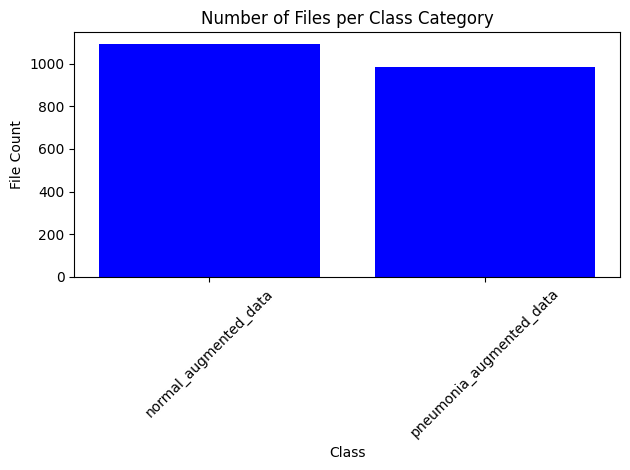

In [4]:
import os
import matplotlib.pyplot as plt

# Set paths
root_dir = '/content/drive/MyDrive/2DCNN_MAJOR/DATASET_FINAL'  # Path to main data folder

# Define class categories
classes = ['normal_augmented_data', 'pneumonia_augmented_data']

# List to store file counts
file_counts = []

# Iterate through each class category
for class_name in classes:
    class_folder = os.path.join(root_dir, class_name)
    file_count = len(os.listdir(class_folder))
    file_counts.append(file_count)
    print(f"{class_name} has {file_count} files.")

# Create a bar graph to visualize file counts
plt.bar(classes, file_counts, color='blue')
plt.xlabel('Class')
plt.ylabel('File Count')
plt.title('Number of Files per Class Category')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the graph
plt.show()


**Features Extraction of Normal and Pneumonia Classes Combinedly saving as Single CSV FIle**

In [5]:
import os
import librosa
import numpy as np
import pandas as pd

# Set paths
root_dir = '/content/drive/MyDrive/2DCNN_MAJOR/DATASET_FINAL'  # Path to the directory containing both Pneumonia and Normal folders
output_dir = '/content/drive/MyDrive/2DCNN_MAJOR/Features/Features_Output'  # Directory to save CSV file

# Define classes
classes = ['pneumonia_augmented_data', 'normal_augmented_data']
num_mfccs = 20  # Number of MFCC coefficients
num_chroma = 20  # Number of chroma coefficients
clip_length = 4  # Clip duration in seconds

feature_data = []

# Define function to extract features and adjust clip length
def extract_features(file_path, clip_length):
    try:
        audio, sr = librosa.load(file_path, sr=None, duration=clip_length)
        if len(audio) < sr * clip_length:
            padding = np.zeros(sr * clip_length - len(audio))
            audio = np.concatenate((audio, padding))
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfccs)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr, n_chroma=num_chroma)
        return mfccs, chroma
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

# Iterate through each class
for class_name in classes:
    class_folder = os.path.join(root_dir, class_name)

    for file_name in os.listdir(class_folder):
        file_path = os.path.join(class_folder, file_name)
        mfccs, chroma = extract_features(file_path, clip_length)

        if mfccs is not None and chroma is not None:
            label = class_name  # Use class name as label
            feature_data.append((mfccs, chroma, label))

# Filter out entries with None values
feature_data = [data for data in feature_data if all(item is not None for item in data[:2])]

# Calculate the minimum number of frames among all features
min_frames = min(data[0].shape[1] for data in feature_data)

# Calculate the mean of each feature across frames
mean_features = []
for data in feature_data:
    mfcc_mean = np.mean(data[0][:, :min_frames], axis=1)
    chroma_mean = np.mean(data[1][:, :min_frames], axis=1)
    mean_features.append(np.concatenate((mfcc_mean, chroma_mean)))

mean_features = np.array(mean_features)

# Add class labels as a separate column
class_labels = np.array([data[2] for data in feature_data])

# Create column labels
columns = []
for i in range(num_mfccs):
    columns.append(f'mean_mfcc_{i}')
for i in range(num_chroma):
    columns.append(f'mean_chroma_{i}')
columns.append('label')

# Create a DataFrame with mean features and class labels
df = pd.DataFrame(data=np.hstack((mean_features, class_labels.reshape(-1, 1))),
                  columns=columns)

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the DataFrame to CSV
output_file = os.path.join(output_dir, 'Pneumonia_and_Normal_dataset.csv')
df.to_csv(output_file, index=False)
print("Combined Features with Labels and Chroma shape:", df.shape)


Combined Features with Labels and Chroma shape: (2077, 41)


**Reading and Printing CSV**

In [7]:
 df=pd.read_csv("/content/drive/MyDrive/2DCNN_MAJOR/Features/Features_Output/Pneumonia_and_Normal_dataset.csv")
print(df)



      mean_mfcc_0  mean_mfcc_1  mean_mfcc_2  mean_mfcc_3  mean_mfcc_4  \
0     -254.651276    93.596184   -63.766830     4.868380   -35.600468   
1     -224.777847   159.005997   -51.691196    30.314028   -19.840466   
2     -232.894699   114.862389   -57.028324    25.958532   -41.147961   
3     -490.247212    36.184395    -6.178181     0.335944    -8.269308   
4     -531.471407    58.387662   -14.303664    10.282837    -6.985420   
...           ...          ...          ...          ...          ...   
2072  -635.220084    17.972983   -15.236700    -0.331691   -13.695560   
2073  -553.454632    65.516537   -26.901944     1.450587    -8.810319   
2074  -523.128678    74.784614   -27.811915     3.989596    -9.870208   
2075  -633.702359    37.875004   -37.113437    -5.614920   -12.678573   
2076  -752.024042     7.772547    -9.742081     3.495438    -6.726049   

      mean_mfcc_5  mean_mfcc_6  mean_mfcc_7  mean_mfcc_8  mean_mfcc_9  ...  \
0       -5.435644   -10.272424     1.113559  

**Label Encoding CSV**

In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the dataset from a CSV file
csv_file_path = '/content/drive/MyDrive/2DCNN_MAJOR/Features/Features_Output/Pneumonia_and_Normal_dataset.csv'
df = pd.read_csv(csv_file_path)

# Explicitly convert the "label" column to strings
df['label'] = df['label'].astype(str)

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit the LabelEncoder to your class labels and transform them
df['label'] = label_encoder.fit_transform(df['label'])

# Save the DataFrame with encoded labels to a specific folder in your Google Drive
output_csv_file = '/content/drive/MyDrive/2DCNN_MAJOR/Features/Features_Output/encoded_dataset.csv'
df.to_csv(output_csv_file, index=False)

print("Label encoding completed and saved to", output_csv_file)


Label encoding completed and saved to /content/drive/MyDrive/2DCNN_MAJOR/Features/Features_Output/encoded_dataset.csv


**Reading and Printing Lable Encoded CSV**

In [9]:
df=pd.read_csv("/content/drive/MyDrive/Features/Features_Output/encoded_dataset.csv")
print(df)

      mean_mfcc_0  mean_mfcc_1  mean_mfcc_2  mean_mfcc_3  mean_mfcc_4  \
0     -261.129425    95.199074   -50.478783    15.721434   -38.228519   
1     -342.552685    70.061839   -47.863924    10.097779   -25.888996   
2     -369.456658   136.831240   -15.335107    -3.933416   -11.415353   
3     -476.868496    45.862944   -17.587941     1.821178   -16.253449   
4     -446.717885    57.025697   -34.181515     1.634024   -16.761943   
...           ...          ...          ...          ...          ...   
1233  -708.334290   -50.674076    19.771763   -12.945270    -3.575535   
1234  -336.010773   -22.850306     2.430060    -0.085436    -4.115896   
1235  -715.325867   -50.772499    20.677490   -14.059664    -3.522715   
1236  -662.606750   -42.580269    14.376425    -7.469673    -8.689781   
1237  -665.436035   -66.511421    23.462692   -11.154595    -3.126693   

      mean_mfcc_5  mean_mfcc_6  mean_mfcc_7  mean_mfcc_8  mean_mfcc_9  ...  \
0        4.253804   -27.552452     3.452351  

**2D CNN Implementation, Loss Curves and Accuracy Curves**

Training the 2D CNN model...
Epoch 1/31
38/38 [==============================] - 2s 17ms/step - loss: 3.7816 - accuracy: 0.5020 - val_loss: 1.5325 - val_accuracy: 0.5269
Epoch 2/31
38/38 [==============================] - 0s 7ms/step - loss: 1.1693 - accuracy: 0.5415 - val_loss: 0.6480 - val_accuracy: 0.6707
Epoch 3/31
38/38 [==============================] - 0s 8ms/step - loss: 0.7213 - accuracy: 0.5562 - val_loss: 0.6546 - val_accuracy: 0.6287
Epoch 4/31
38/38 [==============================] - 0s 7ms/step - loss: 0.6824 - accuracy: 0.5763 - val_loss: 0.6510 - val_accuracy: 0.6287
Epoch 5/31
38/38 [==============================] - 0s 7ms/step - loss: 0.6631 - accuracy: 0.6058 - val_loss: 0.6565 - val_accuracy: 0.6527
Epoch 6/31
38/38 [==============================] - 0s 7ms/step - loss: 0.6598 - accuracy: 0.6071 - val_loss: 0.6467 - val_accuracy: 0.6587
Epoch 7/31
38/38 [==============================] - 0s 6ms/step - loss: 0.6511 - accuracy: 0.6178 - val_loss: 0.6452 - val_accurac

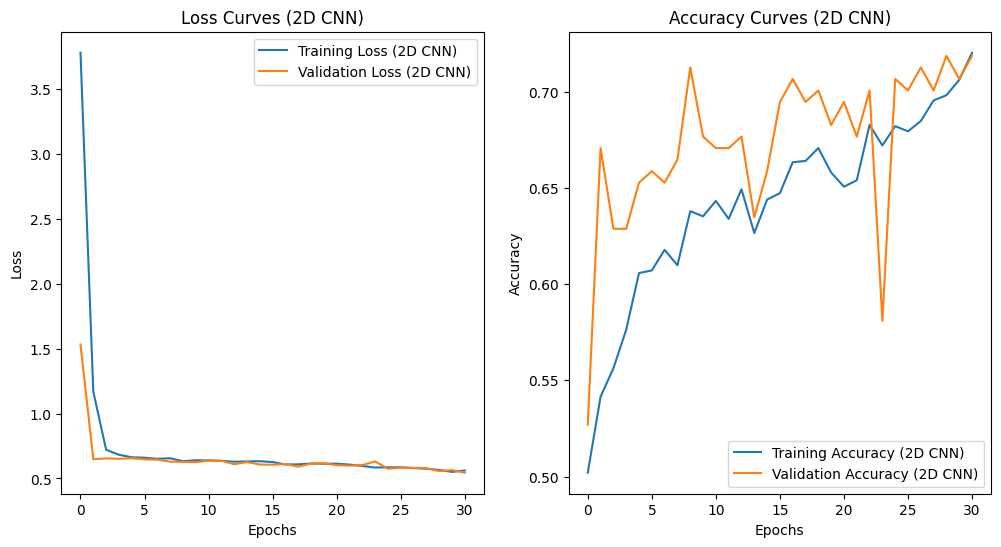

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load the CSV file with features
csv_file = '/content/drive/MyDrive/2DCNN_MAJOR/Features/Features_Output/encoded_dataset.csv'  # Replace with your CSV file path
data = pd.read_csv(csv_file)

# Split data into features (X) and labels (y)
X = data.iloc[:, :-1].values  # Exclude the last column ('label')
y = data['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the features for the 2D CNN input format
num_rows, num_columns =10, 4  # Adjust as needed based on your feature dimensions
X_train_reshaped = X_train.reshape(X_train.shape[0], num_rows, num_columns, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], num_rows, num_columns, 1)

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Build the 2D CNN model
model_cnn2d = Sequential()
model_cnn2d.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(num_rows, num_columns, 1)))
model_cnn2d.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2d.add(Flatten())
model_cnn2d.add(Dense(128, activation='relu'))
model_cnn2d.add(Dropout(0.5))
model_cnn2d.add(Dense(len(np.unique(y)), activation='softmax'))

# Compile the model with the desired optimizer and loss function
model_cnn2d.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the 2D CNN model and capture the training history
print("Training the 2D CNN model...")
history_cnn2d = model_cnn2d.fit(X_train_reshaped, y_train_one_hot, epochs=31, batch_size=40, validation_split=0.1, verbose=1)

# Evaluate the 2D CNN model on the test set
print("\nEvaluating the 2D CNN model on the test set...")
loss_cnn2d, accuracy_cnn2d = model_cnn2d.evaluate(X_test_reshaped, y_test_one_hot)
print(f"Test Loss (2D CNN): {loss_cnn2d:.4f}")
print(f"Test Accuracy (2D CNN): {accuracy_cnn2d:.4f}")

# Predict class labels on the test set using the 2D CNN model
y_pred_cnn2d = np.argmax(model_cnn2d.predict(X_test_reshaped), axis=1)

# Print classification report for the 2D CNN model
class_report_cnn2d = classification_report(y_test, y_pred_cnn2d)
print("Classification Report (2D CNN):")
print(class_report_cnn2d)

# Plot training history for the 2D CNN model (optional)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_cnn2d.history['loss'], label='Training Loss (2D CNN)')
plt.plot(history_cnn2d.history['val_loss'], label='Validation Loss (2D CNN)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves (2D CNN)')

plt.subplot(1, 2, 2)
plt.plot(history_cnn2d.history['accuracy'], label='Training Accuracy (2D CNN)')
plt.plot(history_cnn2d.history['val_accuracy'], label='Validation Accuracy (2D CNN)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves (2D CNN)')

plt.show()


**Save Model**

In [16]:
# Save the trained model to a file
model_cnn2d.save('/content/drive/MyDrive/2DCNN_MAJOR/Model_Saved/Model2D.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 8, 2, 64)          640       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 1, 64)          0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 2)                 258       
                                                      

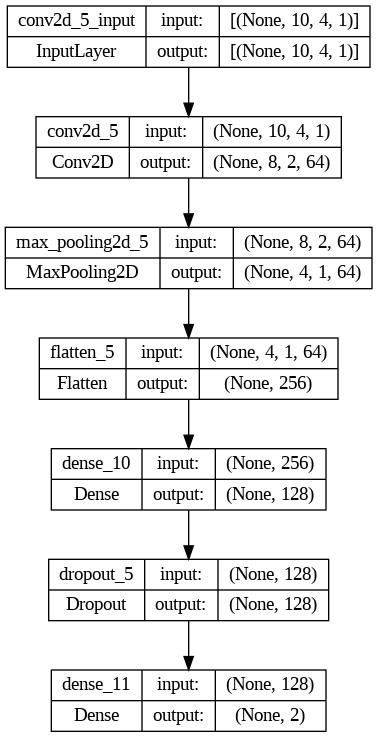

In [23]:

from tensorflow.keras.utils import plot_model
from IPython.display import Image

model_cnn2d.summary()

# Save the model architecture as a jpg file
model_architecture_path = '/content/drive/MyDrive/2DCNN_MAJOR/Model_Saved/2DCNN_model_architecture.jpg'  # Replace with your desired file path
plot_model(model_cnn2d, to_file=model_architecture_path, show_shapes=True, show_layer_names=True)

print(f"2D CNN Model architecture saved to {model_architecture_path}")

# Display the saved architecture image
Image(model_architecture_path)

**Making Predictions**

In [26]:
import tensorflow as tf

# Load the trained model
model_path = '/content/drive/MyDrive/2DCNN_MAJOR/Model_Saved/Model2D.h5'
loaded_model = tf.keras.models.load_model(model_path)
import librosa
import numpy as np

# Constants for feature extraction
SAMPLE_RATE = 22050
DURATION = 4
MFCC_FEATURES = 2  # Change this to match the model's input shape

# Function to extract MFCC features from an audio clip
def extract_features(file_path, target_length):
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    mfccs = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=MFCC_FEATURES)

    # Pad or truncate to the target length
    if mfccs.shape[1] < target_length:
        mfccs = np.pad(mfccs, ((0, 0), (0, target_length - mfccs.shape[1])), mode='constant')
    elif mfccs.shape[1] > target_length:
        mfccs = mfccs[:, :target_length]

    return mfccs

# Path to your audio clip
audio_clip_path = '/content/drive/MyDrive/CustomDataTesting/Recording_p1.wav'

# Extract MFCC features from the audio clip
target_length = 20  # The target length for your model's input shape
audio_features = extract_features(audio_clip_path, target_length)

# Reshape the audio features to match the model's input shape
# Reshape the audio features to match the model's input shape
audio_features = audio_features.reshape(1, 10, 4, 1)  # Ensure the shape matches (None, 10, 4, 1)

# Make predictions
predictions = loaded_model.predict(audio_features)

# Assuming binary classification (Pneumonia and Normal)
if predictions[0][0] > predictions[0][1]:
    predicted_class = 'Normal'
else:
    predicted_class = 'Pneumonia'

print(f'Predicted Class: {predicted_class}')


1/1 [==============================] - 0s 120ms/step
Predicted Class: Pneumonia
